In [1]:
import os, importlib, sys, time, glob

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage
from scipy.sparse import diags
import matplotlib.pyplot as plt

In [3]:
import ladyns as ldn
import ladyns.optimize.core as core

# 0. simulation from LFM

In [5]:
save_dir = "../temp/Appendix_C2"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [6]:
num_time = 50

## cross precision

In [7]:
num_blobs = 3

In [8]:
times = np.array([[1, 1, 12], [21, 18, 6], [32, 37, 9]])

In [9]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

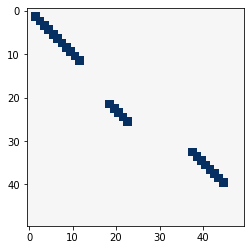

In [10]:
ldn.imshow(np.sum(H0, 0))

In [11]:
rhos = [0.148, 0.163]
precs_auto = [linalg.inv(
    np.exp(-np.square((np.arange(num_time)[:,None]-np.arange(num_time))*rho))
    + 1 * np.eye(num_time))
    for rho in rhos] 

In [12]:
snr = 0.4
prec_latent = np.array(np.block([
    [precs_auto[0]+snr*np.eye(num_time)*np.sum(H0,(0,2)), -snr*np.sum(H0,0)],
    [-snr*np.sum(H0,0).T, precs_auto[1]+snr*np.eye(num_time)*np.sum(H0,(0,1))]
]))

In [13]:
cov_latent = linalg.inv(prec_latent)
sd_latent = np.sqrt(np.diag(cov_latent))
corr_latent = cov_latent / sd_latent / sd_latent[:,None]
chol_latent = linalg.cholesky(corr_latent)

# 1. analysis on simulated estimation 

In [14]:
snrs = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

In [15]:
num_bst = 200

In [16]:
num_sim = np.min([len(glob.glob("%s/result_sim_%.1d_*.npz"%(save_dir, i))) 
                  for i, snr in enumerate(snrs)])

In [17]:
num_sim

60

In [18]:
offset_cross = 10
offset_auto = 10
lambda_diag=0

In [19]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

## true desparsified precision

In [22]:
IOmega_latent = corr_latent.copy()
Omega_latent = np.linalg.inv(IOmega_latent)

In [23]:
core.glasso(Omega_latent, IOmega_latent, corr_latent, lambda_graph)

In [24]:
dspr_latent = 2*Omega_latent - Omega_latent @ corr_latent @ Omega_latent

## plots

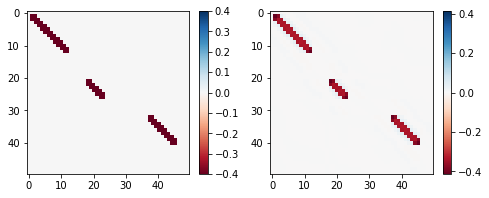

In [25]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1); ldn.imshow(prec_latent[:num_time,num_time:]); plt.colorbar()
plt.subplot(1,2,2); ldn.imshow(dspr_latent[:num_time,num_time:]); plt.colorbar()

Text(0, 0.5, 'series 1 at time $t$')

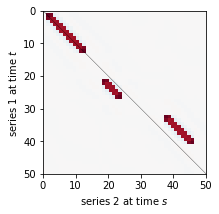

In [26]:
plt.figure(figsize=(3,3))
ldn.imshow(dspr_latent[:num_time,num_time:],
           vmax=0.4, time=[0,50], identity=True)
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")

## load simulation results

In [27]:
Omegas_sim = np.zeros((len(snrs), num_sim, 2*num_time, 2*num_time))
Sigmas_sim = np.zeros((len(snrs), num_sim, 2*num_time, 2*num_time))

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"
                         %(save_dir,iter_snr,iter_sim))
        Omega_est = result["Omega_est"]; Sigma_est=result["Sigma_est"]

        Omegas_sim[iter_snr, iter_sim] = Omega_est
        Sigmas_sim[iter_snr, iter_sim] = Sigma_est

Omegas_bst = result["Omegas_bst"]
Sigmas_bst = result["Sigmas_bst"]

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

## simulation result

In [28]:
Omegas_sim, Sigmas_sim = adj_sign(Omegas_sim, Sigmas_sim)

In [29]:
dsprs_sim = 2*Omegas_sim - Omegas_sim @ Sigmas_sim @ Omegas_sim
std_dspr_sim = np.std(dsprs_sim, 1)

In [31]:
dsprs_bst = 2*Omegas_bst - Omegas_bst @ Sigmas_bst @ Omegas_bst
std_dspr_bst = np.std(dsprs_bst, 0)

## plots

(-0.4, 0.0)

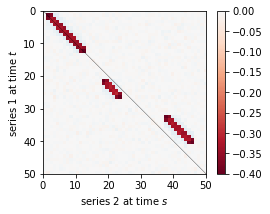

In [209]:
plt.figure(figsize=(4,3))
ldn.imshow(np.mean(dsprs_sim, 1)[1,:num_time,num_time:],
           vmax=0.4, time=[0,50], identity=True)
plt.xlabel(r"series 2 at time $s$"); plt.ylabel(r"series 1 at time $t$")
cbar = plt.colorbar()
cbar.ax.set_ylim(-0.4,0)#; cbar.formatter.set_powerlimits((0, 0))

Text(0.5, 0, 'series 2 at time $s$')

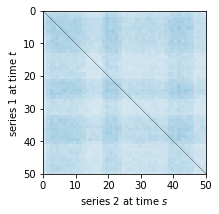

In [38]:
plt.figure(figsize=(3,3))
ldn.imshow(std_dspr_bst[:num_time,num_time:], time=[0,num_time], identity=True, vmax=0.25)
# plt.colorbar()
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

(0.0, 0.25)

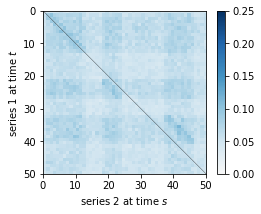

In [212]:
plt.figure(figsize=(4,3))
ldn.imshow(std_dspr_sim[-1,:num_time,num_time:], time=[0,num_time], identity=True, vmax=0.25)
# plt.colorbar()
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
cbar = plt.colorbar()
cbar.ax.set_ylim(0,0.25)#; cbar.formatter.set_powerlimits((0, 0))

Text(0.5, 0, 'series 2 at time $s$')

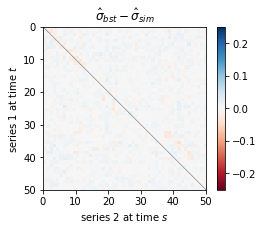

In [40]:
plt.figure(figsize=(4,3))
ldn.imshow(std_dspr_bst[:num_time,num_time:] - std_dspr_sim[-1,:num_time,num_time:], time=[0,num_time], identity=True, vmax=0.25)
plt.colorbar()
plt.title(r'$\hat{\sigma}_{bst} - \hat{\sigma}_{sim}$');plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')

Text(0.5, 1.0, '')

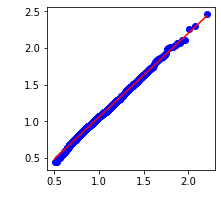

In [41]:
# import matplotlib.gridspec as gridspec
plt.figure(figsize=(3,3))
# gridspec.GridSpec(1,4); plt.subplot2grid((1,4), (0,0), colspan=3, rowspan=1)
stats.probplot(np.square(std_dspr_bst[:num_time,num_time:]/std_dspr_sim[-1,:num_time,num_time:]).flatten(),
                dist='f', sparams=(num_bst-1, num_sim-1), plot=plt)
plt.ylabel(r' ', fontsize=12); plt.xlabel(r' ', fontsize=12); plt.title('')
# ax = plt.subplot2grid((1,4), (0,3))
# ax.axis('off')

# check normality

In [42]:
x_grid = np.linspace(-4, 4, 41)
dnorm_grid = stats.norm(0,1).pdf(x_grid)

In [45]:
rand_inds = np.concatenate([
    np.random.choice(np.where(np.sum(H0,0).flatten() == 0)[0], 3, False),
    np.random.choice(np.where(np.sum(H0,0).flatten() != 0)[0], 3, False)
])

Text(0, 0.5, 'connection')

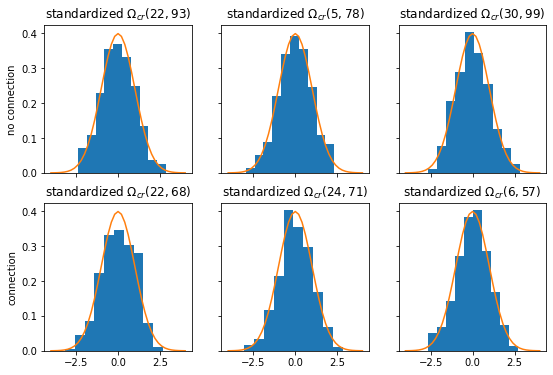

In [46]:
fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=[9.0, 6.0],
                         facecolor='white')
for label, ax in zip(rand_inds, axes.flatten()):
    ax.hist(((dsprs_sim[...,int(label/num_time),num_time+label%num_time]
              - np.mean(dsprs_sim,1)[:,None,int(label/num_time),num_time+label%num_time])
             / std_dspr_sim[:,None,int(label/num_time),num_time+label%num_time]).flatten(),
             density=True)
    ax.plot(x_grid, dnorm_grid)
    ax.set_title(r'standardized $\Omega_{cr}(%d,%d)$'
                  %(int(label/num_time),num_time+label%num_time))
axes[0,0].set_ylabel('no connection')
axes[1,0].set_ylabel('connection')

Text(0.5, 0, 'quantiles of $N(0,1)$')

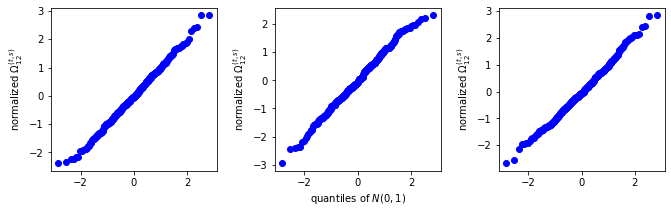

In [47]:
fig, axes = plt.subplots(1, 3, #sharey=True, sharex=True,
                         figsize=[11.0, 3.0], facecolor='white')
plt.subplots_adjust(wspace=0.35)
for label, ax in zip(rand_inds[:3], axes.flatten()):
    stats.probplot(((dsprs_sim[...,int(label/num_time),num_time+label%num_time]
                   - np.mean(dsprs_sim,1)[:,None,int(label/num_time),num_time+label%num_time])
                   / std_dspr_sim[:,None,int(label/num_time),num_time+label%num_time]).flatten(),
                   dist='norm', fit=False, plot=ax)
    # ax.plot((-3,3),(-3,3), color='black')
    ax.set_xlabel(r''); ax.set_ylabel(r'normalized $\Omega_{12}^{(t,s)}$')
    ax.set_title('')

axes[1].set_xlabel(r'quantiles of $N(0,1)$')
#     ax.set_title(r'Q-Q $\Omega_{12}^{(%d,%d)}$ vs. norm'
#                   %(int(label/num_time),num_time+label%num_time))
# axes[0,0].set_ylabel('no connection')
# axes[1,0].set_ylabel('connection')

# 3. FDR from estimated variance

## p-values

In [53]:
# pvals_bst = np.zeros((len(snrs), num_sim, num_time, num_time))
pvals_bst_norm = np.zeros((len(snrs), num_sim, num_time, num_time))

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr, iter_sim))
        Omega_est=result["Omega_est"]; Sigma_est=result["Sigma_est"]
        Omegas_bst=result["Omegas_bst"]; Sigmas_bst=result["Sigmas_bst"]

        dspr_est = 2*Omega_est - Omega_est@Sigma_est@Omega_est
        dsprs_bst = 2*Omegas_bst - Omegas_bst@Sigmas_bst@Omegas_bst
        std_dspr_bst = np.std(dsprs_bst, 0)
        
#         dist_dspr_est = (np.abs(np.mean(dsprs_bst,0))[:num_time,num_time:]
#                          /std_dspr_bst[:num_time,num_time:]).flatten()
#         dist_dspr_bst = (np.abs(dsprs_bst)[:,:num_time,num_time:]
#                          /std_dspr_bst[:num_time,num_time:]).flatten()
        
#         map_sort = np.argsort(np.concatenate([dist_dspr_est, dist_dspr_bst]))
#         inv_sort = np.argsort(map_sort)
#         cdf_bst = np.reshape(np.cumsum(
#                 np.concatenate([np.zeros(dist_dspr_est.shape), 
#                                 np.ones(dist_dspr_bst.shape)])[map_sort]
#             )[inv_sort[:dist_dspr_est.shape[0]]] / dist_dspr_bst.shape[0], 
#             (num_time, num_time))
        
#         pvals_bst[iter_snr, iter_sim] = np.clip(1-cdf_bst, 1e-10, 1-1e-10)
        
#         pvals_bst_norm[iter_snr, iter_sim] = np.clip(2*stats.norm.cdf(
#             -np.abs(dspr_est) 
#             #-np.abs(np.mean(dsprs_bst,0))
#             /std_dspr_bst)[:num_time,num_time:], 1e-10, 1-1e-10)
        
        pvals_bst_norm[iter_snr,iter_sim] = np.clip(stats.norm.cdf(
            dspr_est
            /np.std(dsprs_bst,0))[:num_time,num_time:], 1e-10, 1-1e-10)

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

## get discoveries

In [54]:
alphas = np.linspace(0, 0.2, 11)

In [55]:
rejs_STAR_bst = np.full((len(snrs), num_sim,) + alphas.shape + (num_time, num_time), False)
rejs_BH_bst = np.full((len(snrs), num_sim,) + alphas.shape + (num_time, num_time), False)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write('%d-%d-th simulation\n'%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()  
        
        # STAR process
        _, _, _, rej_sim = \
        inf.STAR_seq_step(pvals_bst_norm[iter_snr, iter_sim], prop_carve=0.05, alphas=alphas,
                          sigma=1.0, mux_init=-np.log(0.01), roi=time_graph_cross)
        rejs_STAR_bst[iter_snr, iter_sim] = rej_sim
        
        # BH process
        p_sorted = np.concatenate([[0], np.sort(pvals_bst_norm[iter_snr, iter_sim].flatten())])
        for iter_alpha, alpha in enumerate(alphas):
            k_hat = np.max(np.where(np.linspace(0, alpha, num_time**2+1) >= p_sorted))        
            rejs_BH_bst[iter_snr, iter_sim, iter_alpha] \
            = pvals_bst_norm[iter_snr, iter_sim] <= k_hat * alpha / num_time**2

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

## get rejected blobs

In [56]:
rej_blobs_STAR_bst = np.zeros((len(snrs), num_sim,) + alphas.shape + (num_time, num_time))
num_blobs_STAR_bst = np.zeros((len(snrs), num_sim,) + alphas.shape)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, alpha in enumerate(alphas):
            mask_cp = rejs_STAR_bst[iter_snr, iter_sim, iter_alpha].copy()
            iter_blob = 0
            while np.any(mask_cp):
                iter_blob += 1
                queue = [tuple(np.transpose(np.where(mask_cp))[0])]
                mask_cp[queue[0]] = False
                while len(queue) > 0:
                    cur = queue.pop(0)
                    rej_blobs_STAR_bst[iter_snr, iter_sim, iter_alpha,
                                        cur[0], cur[1]] = iter_blob
                    if cur[0] > 0:
                        if mask_cp[cur[0]-1, cur[1]]:
                            queue.append((cur[0]-1, cur[1]))
                            mask_cp[cur[0]-1, cur[1]] = False
                    if cur[0] < num_time-1:
                        if mask_cp[cur[0]+1, cur[1]]:
                            queue.append((cur[0]+1, cur[1]))
                            mask_cp[cur[0]+1, cur[1]] = False
                    if cur[1] > 0:
                        if mask_cp[cur[0], cur[1]-1]:
                            queue.append((cur[0], cur[1]-1))
                            mask_cp[cur[0], cur[1]-1] = False
                    if cur[1] < num_time-1:
                        if mask_cp[cur[0], cur[1]+1]:
                            queue.append((cur[0], cur[1]+1))
                            mask_cp[cur[0], cur[1]+1] = False
            num_blobs_STAR_bst[iter_snr, iter_sim, iter_alpha] = iter_blob

## calculate fdrs

In [57]:
H0_sm = np.array([np.sum(H0,0) > 0 for _ in enumerate(snrs)])

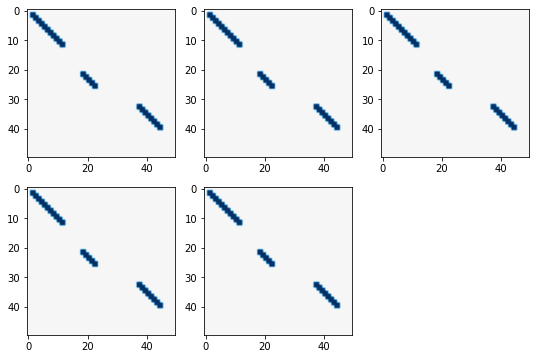

In [59]:
plt.figure(figsize=(9,6))
for i, H0_i_sm in enumerate(H0_sm):
    plt.subplot(2,3,i+1); ldn.imshow(H0_i_sm)

In [60]:
fdps_BH_bst = np.sum(rejs_BH_bst > H0_sm[:,None,None], (-2,-1)) \
           / np.maximum(np.sum(rejs_BH_bst, (-2,-1)), 1)  

fnps_BH_bst = np.sum(rejs_BH_bst < H0_sm[:,None,None], (-2,-1)) \
            / np.maximum(np.sum(H0_sm,(-1,-2)), 1)[:,None,None]

## plots

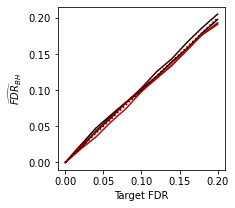

In [66]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fdps_BH_bst[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{FDR}_{BH}$");# plt.legend()

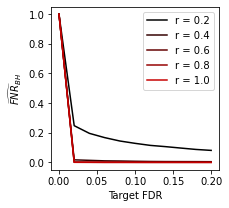

In [70]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fnps_BH_bst[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"r = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat{FNR}_{BH}$"); plt.legend()

# 4. excursion test

In [170]:
a_BH = 0.05

In [172]:
pvals_exc_blob = np.full((len(snrs), num_sim, num_blobs), 0.5)
pvals_exc_null = np.full((len(snrs), num_sim), None, dtype=object)
rbs_pexc = np.zeros((len(snrs), num_sim,) + alphas.shape + (num_time, num_time))
nbs_pexc = np.zeros((len(snrs), num_sim,) + alphas.shape)

for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        sys.__stdout__.write("%d-%d-th simulation\n"%(iter_snr+1, iter_sim+1))
        sys.__stdout__.flush()

        result = np.load("%s/result_sim_%.1d_%.3d.npz"%(save_dir,iter_snr, iter_sim))
        Omega_est=result["Omega_est"]; Sigma_est=result["Sigma_est"]
        Omegas_perm=result["Omegas_bst"]; Sigmas_perm=result["Sigmas_bst"]

        dspr_est = 2*Omega_est - Omega_est@(Sigma_est + lambda_diag*np.eye(2*num_time))@Omega_est
        dsprs_perm = 2*Omegas_perm - Omegas_perm@(Sigmas_perm + lambda_diag*np.eye(2*num_time))@Omegas_perm
        dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))
        dist_dspr_perm = (dsprs_perm[:,:num_time,num_time:]
                         / np.std(dsprs_perm[:,:num_time,num_time:],0))
        
        temp = np.argsort(np.concatenate([
            np.abs(dist_dspr_est[roi]),
            np.abs(dist_dspr_perm[:,roi]).flatten()]))

        ranks = np.empty_like(temp)
        ranks[temp] = np.cumsum(temp > np.sum(roi))
        
        pval_est = np.full(dist_dspr_est.shape, 0.5)
        pvals_perm = np.full(dist_dspr_perm.shape, 0.5)
        pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)
        pvals_perm[:,roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_perm[:,roi])), 1e-10, 1-1e-10)
        
#         pval_est[roi] = 1-(ranks[:np.sum(roi)]/len(temp) - 1/(2*len(temp)))
#         pvals_perm[:,roi] = 1-(ranks[np.sum(roi):].reshape((num_perm,np.sum(roi)))/len(temp) - 1/(2*len(temp)))

        # BH procedure
        p_sorted = np.concatenate([[0], np.sort(pval_est[roi].flatten())])
        k_hat = np.max(np.where(np.linspace(0, a_BH, len(p_sorted)) >= p_sorted))        
        rej_BH_est = pval_est <= k_hat * a_BH / (len(p_sorted)-1)

#         p_sorted = np.concatenate([[0], np.sort(pvals_perm[:,roi].flatten())])   
#         k_hat = np.max(np.where(np.linspace(0, a_BH, len(p_sorted)) >= p_sorted))        
        rejs_BH_perm = pvals_perm <= k_hat * a_BH / (len(p_sorted)-1)

        rb_BH_est = np.zeros((num_time, num_time))
        mask_cp = rej_BH_est.copy(); iter_blob = 0
        while np.any(mask_cp):
            iter_blob += 1
            queue = [tuple(np.transpose(np.where(mask_cp))[0])]
            mask_cp[queue[0]] = False
            while len(queue) > 0:
                cur = queue.pop(0)
                rb_BH_est[cur[0], cur[1]] = iter_blob
                if cur[0] > 0:
                    if mask_cp[cur[0]-1, cur[1]]:
                        queue.append((cur[0]-1, cur[1]))
                        mask_cp[cur[0]-1, cur[1]] = False
                if cur[0] < num_time-1:
                    if mask_cp[cur[0]+1, cur[1]]:
                        queue.append((cur[0]+1, cur[1]))
                        mask_cp[cur[0]+1, cur[1]] = False
                if cur[1] > 0:
                    if mask_cp[cur[0], cur[1]-1]:
                        queue.append((cur[0], cur[1]-1))
                        mask_cp[cur[0], cur[1]-1] = False
                if cur[1] < num_time-1:
                    if mask_cp[cur[0], cur[1]+1]:
                        queue.append((cur[0], cur[1]+1))
                        mask_cp[cur[0], cur[1]+1] = False
        nb_BH_est = iter_blob

        rbs_BH_perm = np.zeros((num_perm, num_time, num_time))
        nbs_BH_perm = np.zeros((num_perm,))
        for iter_perm in range(num_perm):
            mask_cp = rejs_BH_perm[iter_perm].copy(); iter_blob = 0
            while np.any(mask_cp):
                iter_blob += 1
                queue = [tuple(np.transpose(np.where(mask_cp))[0])]
                mask_cp[queue[0]] = False
                while len(queue) > 0:
                    cur = queue.pop(0)
                    rbs_BH_perm[iter_perm, cur[0], cur[1]] = iter_blob
                    if cur[0] > 0:
                        if mask_cp[cur[0]-1, cur[1]]:
                            queue.append((cur[0]-1, cur[1]))
                            mask_cp[cur[0]-1, cur[1]] = False
                    if cur[0] < num_time-1:
                        if mask_cp[cur[0]+1, cur[1]]:
                            queue.append((cur[0]+1, cur[1]))
                            mask_cp[cur[0]+1, cur[1]] = False
                    if cur[1] > 0:
                        if mask_cp[cur[0], cur[1]-1]:
                            queue.append((cur[0], cur[1]-1))
                            mask_cp[cur[0], cur[1]-1] = False
                    if cur[1] < num_time-1:
                        if mask_cp[cur[0], cur[1]+1]:
                            queue.append((cur[0], cur[1]+1))
                            mask_cp[cur[0], cur[1]+1] = False
            nbs_BH_perm[iter_perm] = iter_blob

        mrois_BH_perm = np.zeros(num_perm)
        for iter_perm, (pval, rej_b, num_b) \
        in enumerate(zip(pvals_perm, rbs_BH_perm, nbs_BH_perm)):
            rois = np.zeros(int(num_b+1))
            for iter_blob in range(1, int(num_b+1)):
                rois[iter_blob] = np.sum(-np.log(pval[rej_b == iter_blob]))
            mrois_BH_perm[iter_perm] = np.max(rois)

        rois_BH_est = np.zeros(nb_BH_est+1)
        for iter_blob in range(1, nb_BH_est+1):
            rois_BH_est[iter_blob] = np.sum(-np.log(pval_est[rb_BH_est == iter_blob]))
        p_rois_BH = np.mean(rois_BH_est <= mrois_BH_perm[:,None], 0)
        
        for iter_alpha, alpha in enumerate(alphas):
            temp = np.array(
                [rb_BH_est == i for i in range(int(nb_BH_est+1))]
            ).reshape([-1,num_time,num_time])
            nbs_pexc[iter_snr,iter_sim,iter_alpha] = np.sum(p_rois_BH < alpha)
            rbs_pexc[iter_snr,iter_sim,iter_alpha] = np.sum(temp[p_rois_BH < alpha] \
                * np.arange(1,np.sum(p_rois_BH < alpha)+1)[:,None,None], 0)
            
        for i, H0_i in enumerate(H0):
            pvals_exc_blob[iter_snr,iter_sim,i] \
            = np.min(np.concatenate([[1],
                 p_rois_BH[rb_BH_est[np.logical_and(H0[i]>0, rb_BH_est>0)].astype(int)]]))
            
        pvals_exc_null[iter_snr,iter_sim] \
        = np.min(p_rois_BH[~np.isin(np.arange(nb_BH_est+1),
                        rb_BH_est[np.logical_and(np.sum(H0,0)>0, rb_BH_est>0)].astype(int))])
            
#         for iter_blob in np.arange(num_blobs):
#             rbs_H0 = rb_BH_est[H0[iter_blob] == 1]
#             if np.sum(rbs_H0!=0) <=1:
#                 pvals_exc_blob[iter_snr,iter_sim,iter_blob] = np.nan
#             else:
#                 urbs, urbs_counts = np.unique(rbs_H0[rbs_H0!=0], return_counts=True)
#                 pvals_exc_blob[iter_snr,iter_sim,iter_blob] = \
#                     p_rois_BH[int(urbs[urbs_counts.argmax()])]
        
#         pvals_exc_null[iter_snr,iter_sim] = \
#             p_rois_BH[
#                 ~np.isin(np.arange(nb_BH_est+1),np.unique(np.sum(H0, 0) * rb_BH_est))]

1-1-th simulation
1-2-th simulation
1-3-th simulation
1-4-th simulation
1-5-th simulation
1-6-th simulation
1-7-th simulation
1-8-th simulation
1-9-th simulation
1-10-th simulation
1-11-th simulation
1-12-th simulation
1-13-th simulation
1-14-th simulation
1-15-th simulation
1-16-th simulation
1-17-th simulation
1-18-th simulation
1-19-th simulation
1-20-th simulation
1-21-th simulation
1-22-th simulation
1-23-th simulation
1-24-th simulation
1-25-th simulation
1-26-th simulation
1-27-th simulation
1-28-th simulation
1-29-th simulation
1-30-th simulation
1-31-th simulation
1-32-th simulation
1-33-th simulation
1-34-th simulation
1-35-th simulation
1-36-th simulation
1-37-th simulation
1-38-th simulation
1-39-th simulation
1-40-th simulation
1-41-th simulation
1-42-th simulation
1-43-th simulation
1-44-th simulation
1-45-th simulation
1-46-th simulation
1-47-th simulation
1-48-th simulation
1-49-th simulation
1-50-th simulation
1-51-th simulation
1-52-th simulation
1-53-th simulation
1-

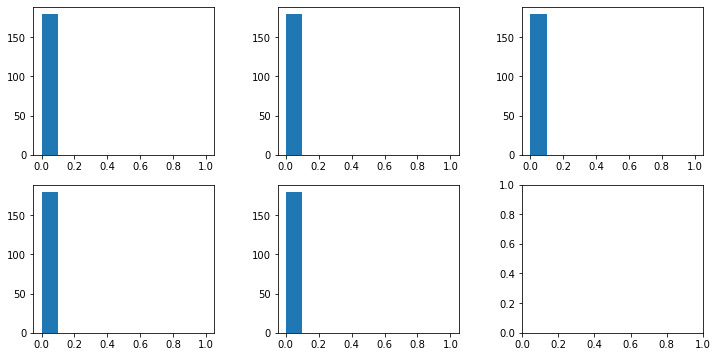

In [176]:
fig, axes = plt.subplots(2, 3, #sharey=True, sharex=True,
                         figsize=[12.0, 6.0], facecolor='white')
plt.subplots_adjust(wspace=0.35)
for iter_snr, (snr, ax) in enumerate(zip(snrs, axes.flatten())):
    ax.hist(pvals_exc_blob[iter_snr].flatten(), range=(0,1))

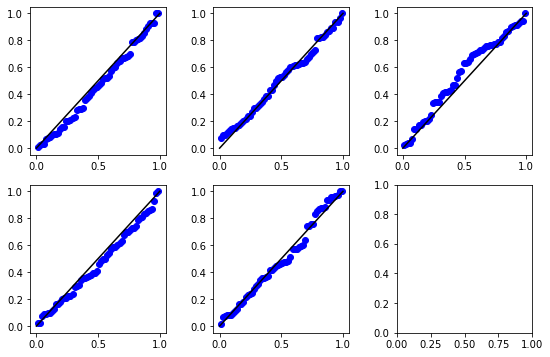

In [177]:
fig, axes = plt.subplots(2, 3, #sharey=True, sharex=True,
                         figsize=[9.0, 6.0], facecolor='white')
plt.subplots_adjust(wspace=0.35)
for iter_snr, (snr, ax) in enumerate(zip(snrs, axes.flatten())):
    stats.probplot(pvals_exc_null[iter_snr], dist='uniform', fit=False, plot=ax)
    ax.plot((0,1),(0,1), color='black')
    ax.set_xlabel(r''); ax.set_ylabel(r'')
    ax.set_title('')

Text(0, 0.5, 'Ordered p-values of \n null clusters')

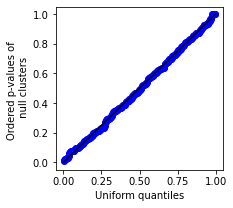

In [179]:
plt.figure(figsize=(3,3))
stats.probplot(pvals_exc_null.flatten(), dist='uniform', fit=False, plot=plt)
plt.plot((0,1),(0,1), color='black')
plt.title("")
plt.xlabel("Uniform quantiles"); plt.ylabel("Ordered p-values of \n null clusters")

In [180]:
p_nominal = np.linspace(0, 1, 2001)
TPR = np.mean(pvals_exc_blob[...,None] < p_nominal, (1,2))
FPR = np.mean(pvals_exc_null[...,None] < p_nominal, (1))

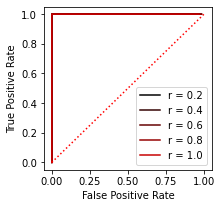

In [181]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(FPR[iter_snr], TPR[iter_snr], color=(50*iter_snr/256, 0, 0), label=r"r = %.1f"%snr)
plt.plot([0,1],[0,1], color='red', ls=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()

Text(0, 0.5, 'True Positive Rate')

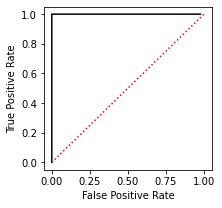

In [182]:
plt.figure(figsize=(3,3))
plt.plot(np.mean(FPR,0), np.mean(TPR,0), color='black')
plt.plot([0,1],[0,1], color='red', ls=':')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")

In [183]:
np.sum((np.mean(TPR,0)[1:]+np.mean(TPR,0)[:-1]) 
       * (np.mean(FPR,0)[1:]-np.mean(FPR,0)[:-1]),0) / 2

0.9766666666666666

## calculate fdrs

In [196]:
rejs_pexc = np.minimum(rbs_pexc, 1)

In [197]:
fdps_pexc = np.sum(rejs_pexc > H0_sm[:,None,None], (-2,-1)) \
           / np.maximum(np.sum(rejs_pexc, (-2,-1)), 1)   

fnps_pexc = np.sum(rejs_pexc < H0_sm[:,None,None], (-2,-1)) \
               / np.maximum(np.sum(H0_sm,(-1,-2)), 1)[:,None,None]

In [198]:
fcds_pexc = nbs_pexc.copy()
for iter_snr, snr in enumerate(snrs):
    for iter_sim in range(num_sim):
        for iter_alpha, _ in enumerate(alphas):
            fcds_pexc[iter_snr, iter_sim, iter_alpha] -= np.sum(np.unique(
                rbs_pexc[iter_snr, iter_sim, iter_alpha, np.any(H0,0)])> 0)
        
fcdps_pexc = fcds_pexc / np.maximum(nbs_pexc, 1)

In [199]:
fcnps_pexc = np.sum(np.all(
    np.logical_or((rejs_pexc[...,None,:,:] < H0), np.logical_not(H0))
    , (-2,-1)), -1) /np.maximum(H0.shape[0], 1)

## plots

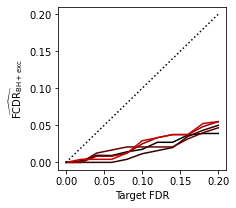

In [203]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcdps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"snr = %.1f"%snr)
plt.plot(alphas, alphas, linestyle=':', color='black')
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCDR}_\mathrm{BH+exc}$"); #plt.legend()

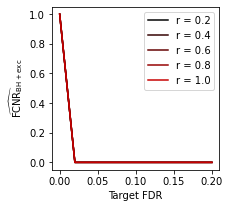

In [207]:
plt.figure(figsize=(3,3))
for iter_snr, snr in enumerate(snrs):
    plt.plot(alphas, np.mean(fcnps_pexc[iter_snr], 0), color=(50*iter_snr/256, 0, 0), label=r"r = %.1f"%snr)
plt.xlabel(r"Target FDR"); plt.ylabel(r"$\widehat\mathrm{FCNR}_\mathrm{BH+exc}$"); plt.legend()